In [1]:
from itertools import product
from utils.binaries import *
from utils.plotting import *
import os

12:14:20 (   +1.5s) [INFO   ] -- import logging
12:14:20 (   +81ms) [INFO   ] -- import numpy as np
12:14:20 (    +9ms) [INFO   ] -- import uncertainties
12:14:21 (  +245ms) [INFO   ] -- import pandas as pd
12:14:21 (    +2ms) [WARNING] -- pandas support to be dropped at some point!
12:14:21 (    +1ms) [INFO   ] -- import binaries.tools as tools
12:14:21 (  +305ms) [INFO   ] -- import matplotlib.pyplot as plt
12:14:21 (  +339ms) [INFO   ] -- import seaborn as so
12:14:21 (    +2ms) [INFO   ] -- import plotting.tools as plot
12:14:21 (    +7ms) [DEBUG  ] -- font size set to 9.5
12:14:21 (    +1ms) [DEBUG  ] -- label size set to 13.0
12:14:21 (    +0ms) [DEBUG  ] -- figure size set to [6.6, 3.3]
12:14:21 (    +1ms) [DEBUG  ] -- markersize set to 2.0
12:14:21 (    +1ms) [DEBUG  ] -- usetex set to False


In [66]:
def visualize(z_close, z_far, l=None):

    from matplotlib.colorbar import ColorbarBase
    from matplotlib.colors import CenteredNorm

    multiplicities = range(5, 45)
    threshold = np.linspace(0.05, 3.00, 295)

    z_close = z_close.reshape((len(multiplicities), len(threshold)))
    z_far = z_far.reshape((len(multiplicities), len(threshold)))
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    for ax, z, distance in zip([ax1, ax2], [z_close, z_far], ['$<750\,$m', '$>750\,$m']):

        ax.set_box_aspect(1)
        image = ax.imshow(z.T, extent=(5, 45, 0.05, 3.00), 
                          aspect='auto', 
                          cmap='coolwarm', 
                          origin='lower',
                          interpolation='none',
                          vmin=-1, vmax=1)

        ax.set_title(distance)
        ax.set_xlabel('occupancy / bins')
        ax.set_yscale('log')
        _ = ax.set_yticks([0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 2.0],["0.2", "0.3", "0.4", "0.6", "0.8", "1.0", "2.0"])
        ax.minorticks_off()

    ax1.set_ylabel('threshold / $I^\mathrm{SSD}_\mathrm{histo}$')

    cax = fig.add_axes([0.97, 0.1, 0.03, 0.8])
    norm = CenteredNorm(0, 1)

    ColorbarBase(cax, norm=norm, cmap=plt.cm.coolwarm, 
                 label=r"$\left(\mathrm{T2}_\mathrm{SSD}-\mathrm{T2}_\mathrm{WCD}\right)\,/\,n_\mathrm{Candidate}$")


In [2]:
run_no = "run01"
src_dir = f"/cr/work/filip/SSDTriggerEfficiency/{run_no}_evaluated"
all_files = [f"{src_dir}/{file}" for file in os.listdir(src_dir)]

df = pd.read_csv(all_files[0], index_col="params")
for file in tools.ProgressBar(all_files[1:]):
    df += pd.read_csv(file, index_col="params")



1/1 [********************] || 00:00:00>00:00:00,    148478.10 it/s


In [14]:
multiplicities = range(5, 45)
threshold = np.linspace(0.05, 3.00, 295)
all_params = list(product(multiplicities, threshold))

container = np.empty((4, len(all_params)))
container[:] = np.nan
x, y, z_close, z_far = container

for index, row in df.iterrows():
    x_, y_ = [float(_) for _ in index[1:-1].split(',')]
    for i, (_x, _y) in enumerate(all_params):
        if _x == x_ and _y == y_: break

    f_far = row.sum_far / row.n_far
    f_close = row.sum_close / row.n_close
    
    x[i] = x_
    y[i] = y_
    z_far[i] = f_far
    z_close[i] = f_close

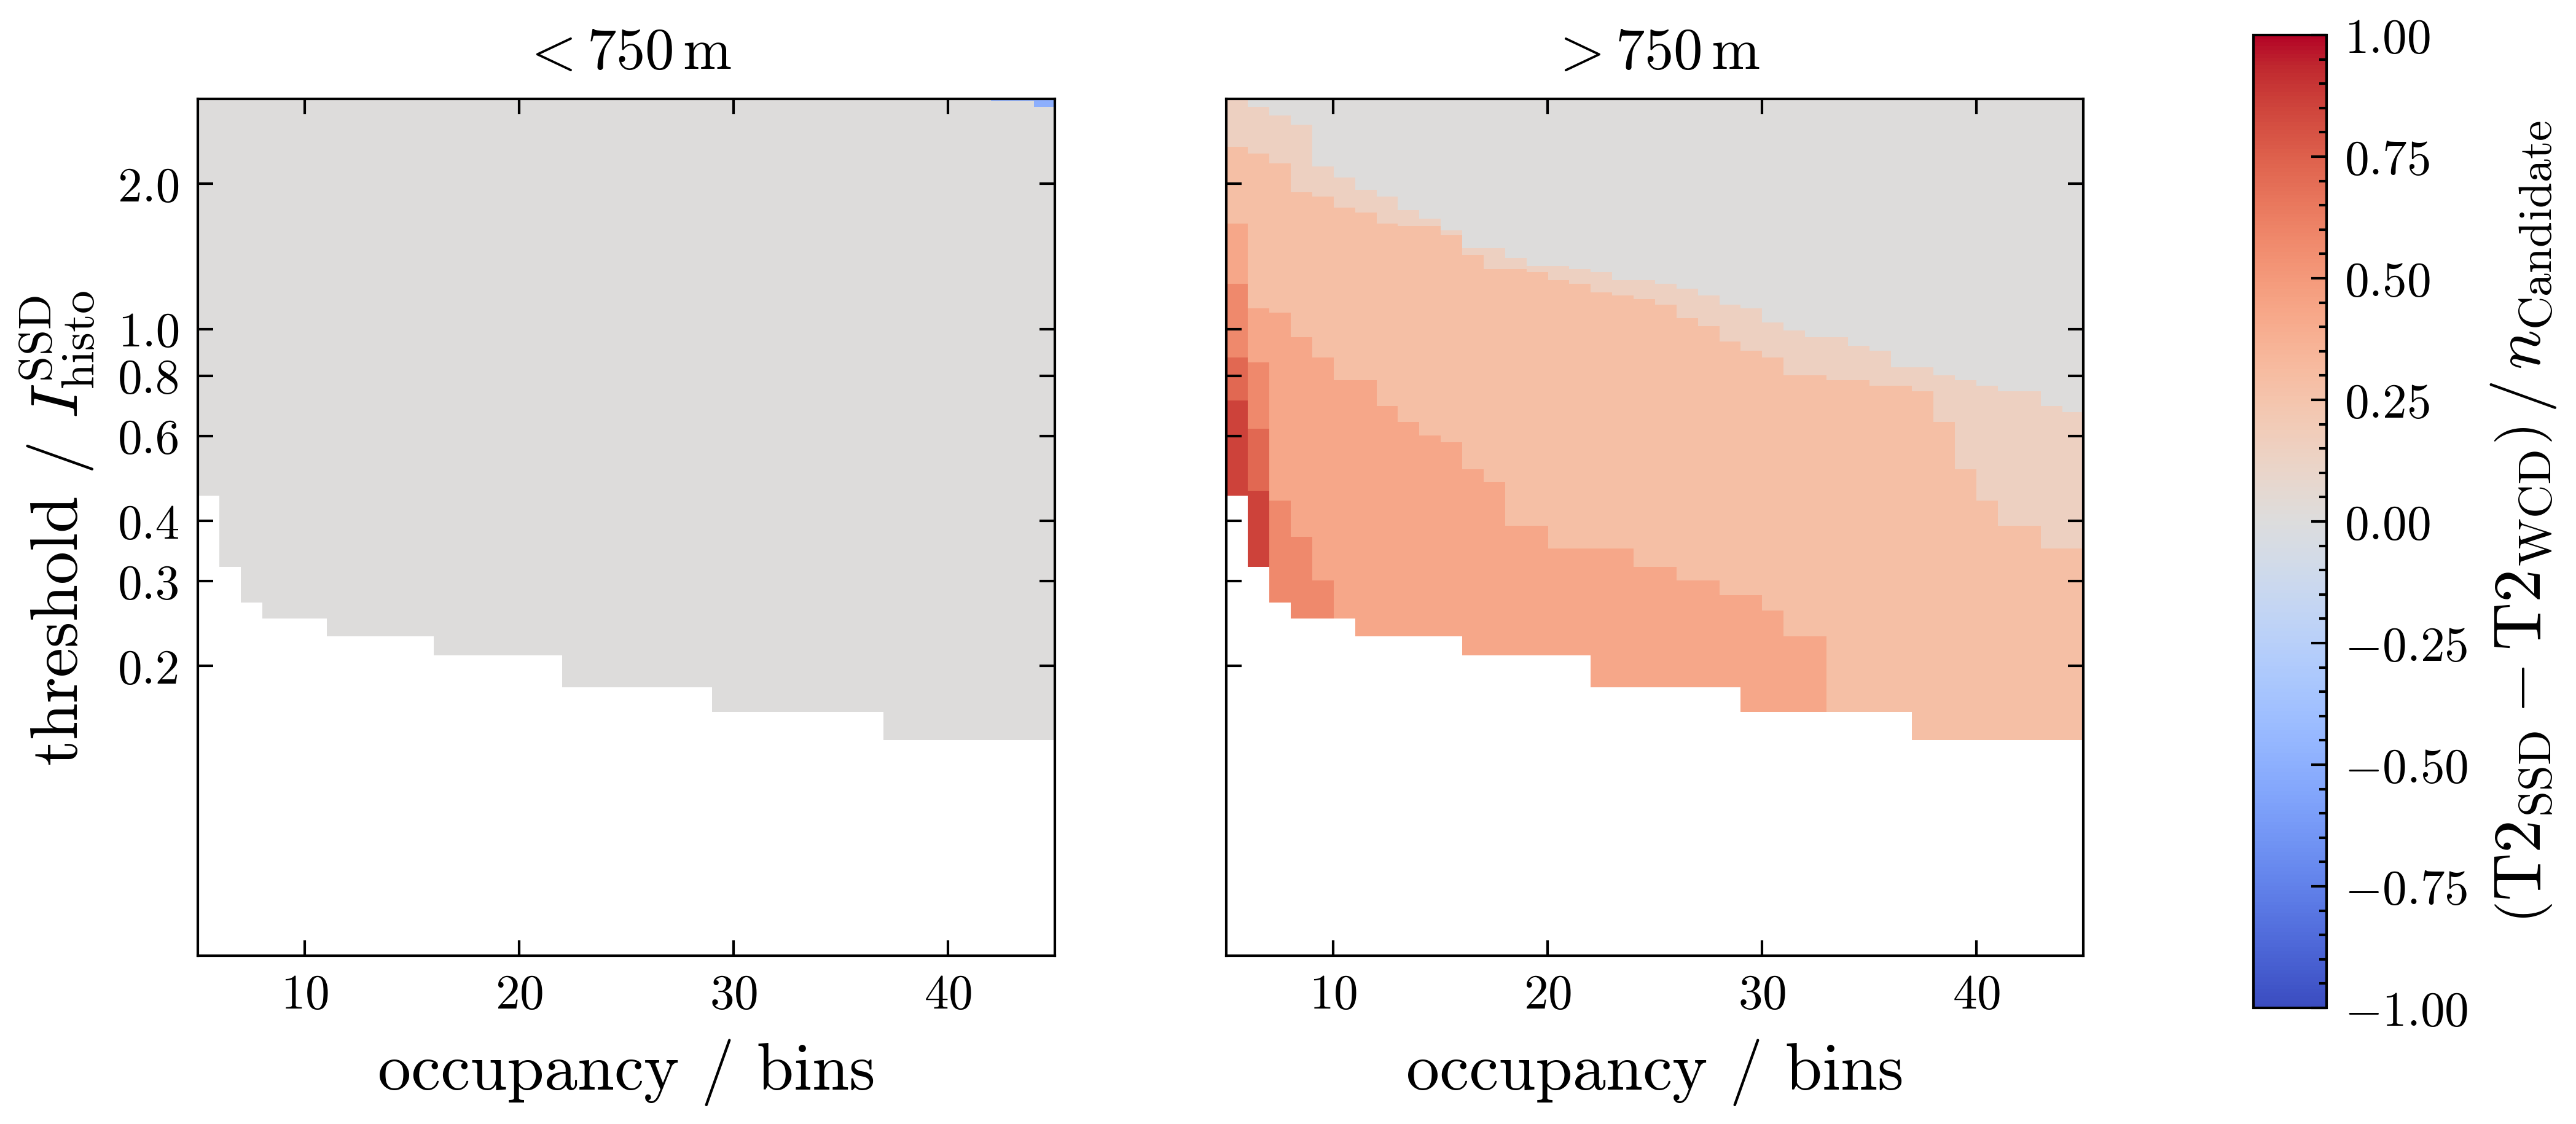

In [67]:
visualize(z_close, z_far)